In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import util
import pfilter_multi as pfilter
from scipy.stats import norm

import matplotlib.pyplot as plt

np.set_printoptions(precision=4)
!pwd

/home/zpyang/git/visnet/src/visnet/notebooks


In [58]:
class Camera:
    def __init__(self, cam_param, cam_pos, cam_att):
        self.param = cam_param
        self.pos = cam_pos
        self.att = cam_att
        self.R_cam = util.so3_exp(self.att)
        self.K = util.get_cam_in(self.param)
        self.R = util.R_model2cam @ self.R_cam # this rotation is kinda goofy but works, TODO: maybe
        self.P = util.get_cam_mat_lie(self.param, self.pos, self.att)
        self.range = 20 # meters
        self.fov = np.deg2rad(90) #degrees, both directions
        
    def __repr__(self):
        return "param: {}, pos: {}, att: {}".format(self.param, self.pos, self.att)
        
    def _get_pixel_pos_hom(self, target_pos):
        return self.P @ util.cart2hom(target_pos)
    
    def _get_pixel_pos(self, target_pos):
        return util.hom2cart(self._get_pixel_pos_hom(target_pos))
    
    def _get_distance(self, target_pos):
        """
        !!!Should not be used directly in estimation!!!
        """
        dist =  np.linalg.norm(target_pos-self.pos)
        return dist
    
    def get_bearing(self, target_pos):
        """
        considers the FOV and range of the camera
        Outside FOV - no measurement
        Outside range - worse measurement, more noise?
        """
        # check FOV on x & y axis of the camera frame
        dist = self._get_distance(target_pos)
        vec = self.R_cam @ (target_pos - self.pos) / dist
        ang1 = np.arctan2(vec[2], vec[0])
        ang2 = np.arctan2(vec[1], vec[0])
        if not(ang1 < self.fov/2 and ang1 > -self.fov/2) or not(ang2 < self.fov/2 and ang2 > -self.fov/2) :
            return np.array([-1, -1])
        
        bearing = self._get_pixel_pos(target_pos)
        if dist > self.range:
            return self.add_pixel_noise(bearing, sigma=20)
        return self.add_pixel_noise(bearing)
        
    def add_pixel_noise(self, pixel_coord, sigma=10):
        return pixel_coord + np.random.normal(0, sigma)
    
class CamNode(Camera):
    def __init__(self, cam_param, cam_pos, cam_att):
        super(CamNode, self).__init__(cam_param, cam_pos, cam_att)
        
    def _get_vec(self, pixel_pos):
        """
        Back projected ray from the camera to the target (approximate)
        """
        pixel_coord = self.add_pixel_noise(pixel_pos)
        K = self.K
        R = self.R
        Bp = np.linalg.inv(K @ R)
        vec = Bp @ util.cart2hom(pixel_pos).astype('int32') # cast to integer because actual pixels are discrete
        vec = vec/np.linalg.norm(vec)
        return vec
    
    def get_measurement(self, target_pos, label):
        """
        Bearing measurements in pixel coordinate (and target identity) 
        The input here is temporary until we have trained the neural net to actually identify targets
        """
        
        bearing = self.get_bearing(target_pos)
        
        # target is unknow if it is too far
        if self._get_distance(target_pos) > self.range:
            label = -1
        if bearing[0] < 0:
            label = -1
        return np.hstack([bearing/2000, label])

cam_param = [642.0926, 642.0926, 1000.5, 1000.5,0]
# [x y z roll pitch yaw]
cam_poses = np.array([
    [20, 20, 12, 0, 0, -2.2],
    [20, -20, 12, 0, 0, 2.2],
#     [-20, -20, 12, 0, 0, 0.7],
#     [-20, 20, 12, 0, 0, -0.7],
])

cam_nodes = [CamNode(cam_param, poses[0:3], poses[3:6]) for poses in cam_poses]

class Target():
    def __init__(self, dynamics_fn, label, state_init, t0):
        self.dynamics_fn = dynamics_fn
        self.label = label
        self.states = state_init
        self.t = t0
        
    def update(self, t):
        state = self.dynamics_fn(self.states[-1,:], t)
        self.states = np.vstack([self.states, state])
        return state

In [59]:
# x0 = np.zeros([1,6])
# t1 = Target(dynamics_fn=dynamics_d, label=0, state_init=x0, t0=0)
# for t in range(100):
#     t1.update(t)
# plt.figure()
# plt.plot(t1.states[:,0], t1.states[:, 1])

In [60]:
def target_traj_circle(t):
    x = 15*np.sin(2 * np.pi * 0.01 * t / 3)
    y = 10*np.cos(2 * np.pi * 0.01 * t / 3)
    z = 20
    return np.array([x,y,z])

def target_traj_straight(t):
    start = -25
    end = 25
    x = start + t * 0.18
    y = 0
    z = 20
    return np.array([x, y, z])

In [61]:
dt = 1/10
A = np.block([
    [np.eye(3), dt*np.eye(3)],
    [np.zeros((3,3)), np.eye(3)]
])
A = np.block([
    [A, np.zeros((6,1))],
    [np.zeros((1,6)), 1]
])

In [69]:
num_cam = 4
n = 5000        # number of particles per step
d = 6          # states to estimate (pos & vel)
h = 2*num_cam  # states of observation (pixel coord * num of cams)
def prior_fn(n):
    pos_x = np.random.uniform(-20, 20, (n,1))
    pos_y = np.random.normal(-20, 20, (n,1))
    pos_z = np.random.normal(10, 25, (n,1))
    vel_x = np.random.normal(0, 1, (n,1))
    vel_y = np.random.normal(0, 1, (n,1))
    vel_z = np.zeros((n,1))
#     label = -np.ones((n,1))
    label = np.random.randint(0, 2, (n,1))
    particles = np.hstack([pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, label])
    print(particles.shape)
    return particles

def observe_fn(x):
    """
    Parameters:
        x : all particles at a step
    Returns:
        observations/measurements from x using the camera projection matrix
    """
    res = 2000 # camera's resolution
    msmt = []
    for xi in x:
        vec = []
        for node in cam_nodes:
            p = node.get_measurement(xi[0:3], xi[-1])
            vec = np.hstack([vec,p])
        msmt.append(vec)
    return np.array(msmt)

def dynamics_d(x):
    """
    Discrete dynamics, last state is the target id
    """

    n = x.shape[0]
    w = np.zeros((7, n))
    w[3:6] = np.random.normal(0, 1, (3,n))
    x_1 = A @ x.T + w
    
    return x_1.T

def classify_fn(x, y):
    pass

def weight_fn(x, y, sigma=1):
    '''
    x: the set of particles, with the last state as the label/id
    y: measurement from camera nodes 
    '''
    dx = (x - y) ** 2
    d = np.ma.sum(dx, axis=1)
    weights = np.exp(-d / (2.0 * sigma ** 2))
    return weights

In [87]:
pf = pfilter.ParticleFilter(
    prior_fn=prior_fn,
    observe_fn=observe_fn,
    dynamics_fn=dynamics_d,
    n_particles=5000,
    resample_fn = pfilter.residual_resample,
    weight_fn=weight_fn,
    n_eff_threshold=1,
)
particles = []
state = []
state_est = []
n_eff = []
t_step = 150
clutter_threshold = 1

for t in range(t_step):
#     print(t)
    target_pos_1 = target_traj_circle(t)
    target_pos_2 = target_traj_straight(t)
    z = []
    random = np.random.uniform(0,1)
    for node in cam_nodes:
        z1 = node.get_measurement(target_pos_1, 1)
#         z2 = node.get_measurement(target_pos_2, 2)
        
        z = np.hstack([z,z1]) # z has size (12,)
    pf.update(z)
    particles.append(pf.particles)
    state_est.append(pf.map_state)
    state.append(np.hstack([target_pos_1, target_pos_2]))
    n_eff.append(pf.n_eff)

particles = np.array(particles)
state = np.array(state)
state_est = np.array(state_est)
err1 = state[:,0:3] - state_est[:, 0:3]
# err2 = state[:,3:6] - state_est[:, 6:9]
n_eff = np.array(n_eff)

(5000, 7)


Text(0, 0.5, 'label')

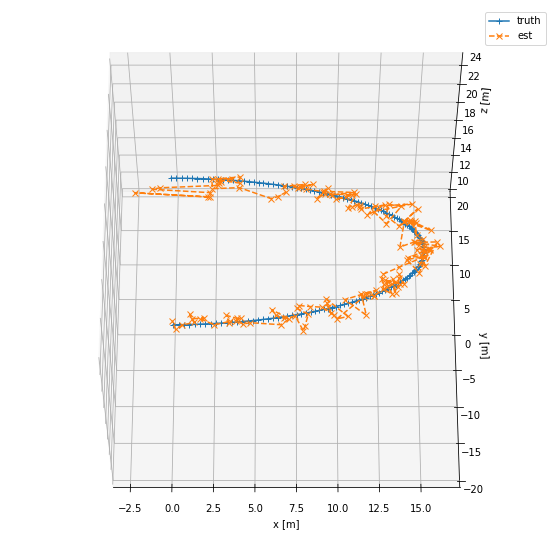

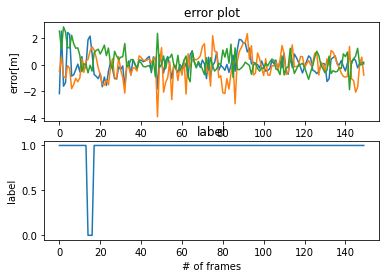

In [88]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
ax.plot3D(state[:,0], state[:,1], state[:,2], '+-', label='truth')
ax.plot3D(state_est[:,0], state_est[:,1], state_est[:,2], 'x--', label='est')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_ylim(-20,20)
ax.set_zlim(10, 25)
ax.view_init(60,-90)

plt.legend()


# plt.figure(figsize=(10,10))
# ax = plt.axes(projection="3d")
# ax.plot3D(state[:,3], state[:,4], state[:,5], '+-', label='truth')
# ax.plot3D(state_est[:,6], state_est[:,7], state_est[:,8], 'x--', label='est')
# ax.set_xlabel('x [m]')
# ax.set_ylabel('y [m]')
# ax.set_zlabel('z [m]')
# ax.set_ylim(-20,20)
# ax.set_zlim(10, 25)
# plt.legend()

plt.figure()
plt.subplot(2,1,1)
plt.plot(err1)
plt.title('error plot')
plt.xlabel('# of frames')
plt.ylabel('error[m]')

plt.subplot(2,1,2)
plt.plot(state_est[:,-1])
plt.title('label')
plt.xlabel('# of frames')
plt.ylabel('label')

<ipython-input-57-b39607f222c6>:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


IndexError: index 7 is out of bounds for axis 2 with size 7

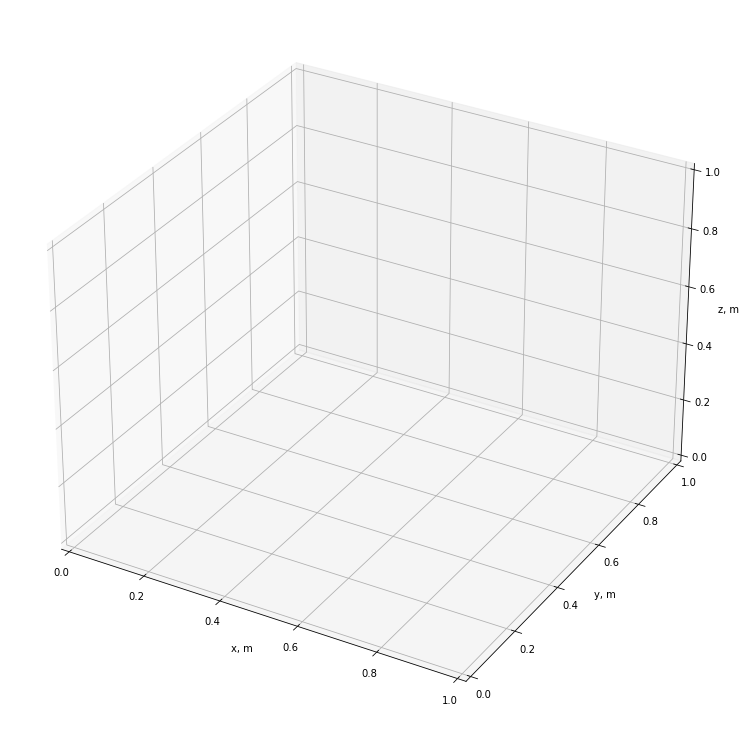

In [57]:
# import mpl_toolkits.mplot3d.axes3d as p3
# import matplotlib.animation as animation
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# # Attaching 3D axis to the figure
# fig = plt.figure(figsize=(10, 10))
# ax = p3.Axes3D(fig)
# ax.set_xlabel('x, m')
# ax.set_ylabel('y, m')
# ax.set_zlabel('z, m')

# # create trajectory data
# cloud_x = np.hstack([particles[0, :, 0], particles[0, :, 6]])
# cloud_y = np.hstack([particles[0, :, 1], particles[0, :, 7]])
# cloud_z = np.hstack([particles[0, :, 2], particles[0, :, 8]])
# cloud = ax.plot3D(cloud_x, cloud_y, cloud_z, 'yo', markersize=3, alpha = 0.3, label='particles')[0]

# est_x = np.array([state_est[0, 0], state_est[0, 6]])
# est_y = np.array([state_est[0, 1], state_est[0, 7]])
# est_z = np.array([state_est[0, 2], state_est[0, 8]])
# est = ax.plot3D(est_x, est_y, est_z, 'rP', markersize=10, label='estimation')[0]

# cam_pos = ax.plot3D(cam_poses[:,0], cam_poses[:,1], cam_poses[:,2], 's', label='cameras')[0]
# plt.legend()
# ax.view_init(60,-90)

# # fps = 5  # frames per second
# # data_period = 0.1  # data period, seconds
# # data_length = dataLines[0].shape[1]
# # duration = data_period * data_length
# # frames = int(np.floor(duration * fps))
# # step = data_length // frames

# def update_lines(i, cloud, est):
#     # NOTE: there is no .set_data() for 3 dim data...
#     x = np.hstack([particles[i, :, 0], particles[i, :, 6]])
#     y = np.hstack([particles[i, :, 1], particles[i, :, 7]])
#     z = np.hstack([particles[i, :, 2], particles[i, :, 8]])
#     cloud.set_data(x, y)
#     cloud.set_3d_properties(z)

#     est_x = np.array([state_est[i, 0], state_est[i, 6]])
#     est_y = np.array([state_est[i, 1], state_est[i, 7]])
#     est_z = np.array([state_est[i, 2], state_est[i, 8]])
#     est.set_data(est_x, est_y)
#     est.set_3d_properties(est_z)
#     return cloud, est

# border = 0.1
# ax.set_xlim3d(-25,25)
# ax.set_ylim3d(-25,25)
# ax.set_zlim3d(0,25)

# ani = FuncAnimation(
#     fig, update_lines, t_step, fargs=(cloud, est),
#     interval=int(1000 / 10), blit=False)
# HTML(ani.to_html5_video())
# # plt.close()